## Importing libraries

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import json

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Loading data

In [2]:
full_train_data = pd.read_csv('train.csv', usecols=['id', 'text', 'target'])
test_data = pd.read_csv('test.csv', usecols = ['id', 'text'])

### Visualizing training data distribution

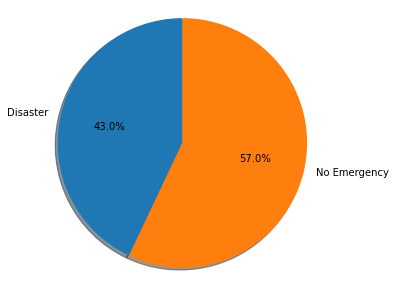

In [3]:
disaster_tweets = full_train_data[full_train_data['target']==1]
no_emergency = full_train_data[full_train_data['target']!=1]

fig = plt.figure(figsize=(5, 5))

# labels for the two classes
labels = 'Disaster', 'No Emergency'

# Sizes for each slide
sizes = [len(disaster_tweets), len(no_emergency)] 

plt.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)

# To ensure pie is drawn as a circle
plt.axis('equal')  

# Display the chart
plt.show()

### Shuffling data

In [4]:
#to shuffle data in training set before splitting
full_train_data = full_train_data.sample(frac=1).reset_index(drop=True)

train_tweets, val_test_tweets, train_labels, val_test_labels = train_test_split(full_train_data['text'], 
                                                                                full_train_data['target'], 
                                                                                  test_size=0.2)

train_tweets = train_tweets.tolist()
train_labels = train_labels.tolist()

val_test_tweets = val_test_tweets.tolist()
val_test_labels = val_test_labels.tolist()

length = len(val_test_tweets)

## Building Model

In [5]:
vocab_size = 10000 #input length in embedding layer, 
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000

In [6]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_tweets)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(train_tweets)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

val_sequence = tokenizer.texts_to_sequences(val_test_tweets)
val_padded = pad_sequences(val_sequence, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Need this block to get it to work with TensorFlow 2.x
training_padded = np.array(training_padded)
training_labels = np.array(train_labels)
    
val_padded = np.array(val_padded)
val_labels = np.array(val_test_labels)

In [7]:
len(train_labels)

6090

In [8]:
num_epochs = 30
    
model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(36, activation='relu'),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
                            ])
        
model.compile(loss='binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
    
# Defining early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
                        monitor = 'val_loss',
                        mode = 'auto',
                        min_delta = 0,
                        patience = 2,
                        verbose = 0, 
                        restore_best_weights = True
                    )

# This function keeps the initial learning rate for the first ten epochs
# and decreases it exponentially after that.
def scheduler(epoch, lr):
    if epoch < 3:
        return lr
    else:
        return lr * tf.math.exp(-0.01)
    
lrscheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [9]:
history = model.fit(
    training_padded, 
    training_labels, 
    epochs=num_epochs, 
    callbacks = [lrscheduler, early_stopping], 
    validation_data=(val_padded, val_labels), 
    verbose=2)

Epoch 1/30
191/191 - 1s - loss: 0.6806 - accuracy: 0.5711 - val_loss: 0.6741 - val_accuracy: 0.5673 - lr: 0.0010 - 1s/epoch - 7ms/step
Epoch 2/30
191/191 - 0s - loss: 0.6035 - accuracy: 0.6760 - val_loss: 0.5449 - val_accuracy: 0.7702 - lr: 0.0010 - 482ms/epoch - 3ms/step
Epoch 3/30
191/191 - 0s - loss: 0.4311 - accuracy: 0.8245 - val_loss: 0.4621 - val_accuracy: 0.8050 - lr: 0.0010 - 472ms/epoch - 2ms/step
Epoch 4/30
191/191 - 0s - loss: 0.3107 - accuracy: 0.8793 - val_loss: 0.4664 - val_accuracy: 0.7971 - lr: 9.9005e-04 - 460ms/epoch - 2ms/step
Epoch 5/30
191/191 - 1s - loss: 0.2470 - accuracy: 0.9057 - val_loss: 0.4902 - val_accuracy: 0.8037 - lr: 9.8020e-04 - 645ms/epoch - 3ms/step


In [10]:
test_data_tweets = test_data['text']
test_data_tweets = test_data_tweets.tolist()

test_data_sequence = tokenizer.texts_to_sequences(test_data_tweets)
test_data_padded = pad_sequences(test_data_sequence, maxlen=max_length, padding=padding_type, truncating=trunc_type)

test_data_padded = np.array(test_data_padded)

### Model prediction

In [11]:
predicted = model.predict(test_data_padded)

y_predicted = np.where(predicted>0.5, 1, 0)
y_predicted = y_predicted.reshape((1,3263))[0]

### Saving output to csv.

In [12]:
output1 = pd.DataFrame()
output1['id'] = test_data['id']
output1['target'] = y_predicted
output1.to_csv('submission_v1.csv', index=False)